In [1]:
# install wandb
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 35.9 MB/s 
     |████████████████████████████████| 182 kB 56.3 MB/s 
     |████████████████████████████████| 168 kB 73.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 71.3 MB/s 
     |████████████████████████████████| 166 kB 69.1 MB/s 
     |████████████████████████████████| 162 kB 69.8 MB/s 
     |████████████████████████████████| 162 kB 64.6 MB/s 
     |████████████████████████████████| 158 kB 72.3 MB/s 
     |████████████████████████████████| 157 kB 73.7 MB/s 
     |████████████████████████████████| 157 kB 68.6 MB/s 
     |████████████████████████████████| 157 kB 64.6 MB/s 
     |████████████████████████████████| 157 kB 71.5 MB/s 
     |████████████████████████████████| 157 kB 70.9 MB/s 
     |████████████████████████████████| 157 kB 68.7 MB/s 
     |████████████████████████████████| 157 kB 72.0 MB/s 
     |████████████████████████████████| 156 kB 65.2 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 11.8 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 2.2 MB/s 


In [3]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
from codecarbon import EmissionsTracker

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "transfer_learning_VGG-16",
  "artifact_name": "animals_raw_data:latest",
  "artifact_name_feature": "clean_data:latest",
  "artifact_name_target": "label:latest"
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="gildson",project=args["project_name"], job_type="transfer_learnimg")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: gildson. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 94.21MB. 950 files... 
wandb:   950 of 950 files downloaded.  
Done. 0:0:31.3
22-11-2022 00:23:55 Path: ./artifacts/animals_raw_data:v0


In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 950 files belonging to 5 classes.


In [9]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [10]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 30
Number of train batches: 24
Number of validation batches: 5
Number of test batches: 1


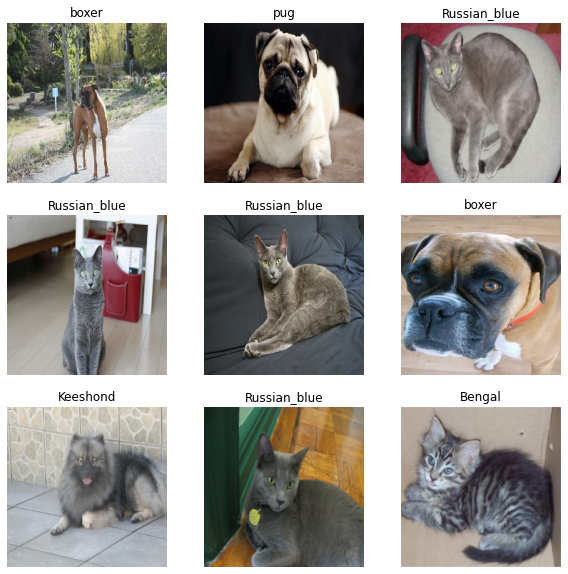

In [11]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

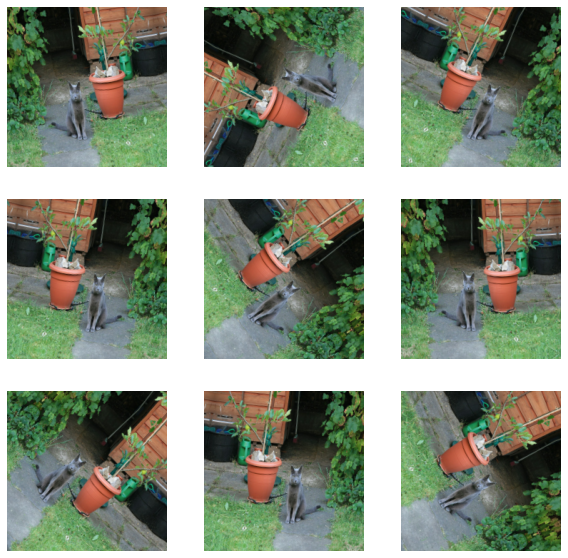

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Transfer learning with feature extractor

In [15]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58889256/58889256 [==============================] - 3s 0us/step


In [16]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [18]:
model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [20]:
n_classes=5
prediction_layer = tf.keras.layers.Dense(n_classes,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                         compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
22-11-2022 00:25:43 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5254: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 8.0524 - accuracy: 0.2955

22-11-2022 00:25:56 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:25:57 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.5s


24/24 [==============================] - 14s 515ms/step - loss: 8.0524 - accuracy: 0.2955 - val_loss: 6.3374 - val_accuracy: 0.3750
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 6.2103 - accuracy: 0.3245

22-11-2022 00:26:12 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:26:13 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.6s


24/24 [==============================] - 16s 632ms/step - loss: 6.2103 - accuracy: 0.3245 - val_loss: 4.2324 - val_accuracy: 0.4500
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 5.1103 - accuracy: 0.3522

22-11-2022 00:26:23 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:26:24 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.4s


24/24 [==============================] - 11s 412ms/step - loss: 5.1103 - accuracy: 0.3522 - val_loss: 3.8902 - val_accuracy: 0.4750
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 4.1340 - accuracy: 0.4129

22-11-2022 00:26:34 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:26:35 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 427ms/step - loss: 4.1340 - accuracy: 0.4129 - val_loss: 2.9112 - val_accuracy: 0.5437
Epoch 5/20
24/24 [==============================] - ETA: 0s - loss: 3.9816 - accuracy: 0.4077

22-11-2022 00:26:55 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:26:56 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.4s


24/24 [==============================] - 12s 447ms/step - loss: 3.9816 - accuracy: 0.4077 - val_loss: 2.7330 - val_accuracy: 0.5125
Epoch 6/20
24/24 [==============================] - ETA: 0s - loss: 3.5176 - accuracy: 0.4565

22-11-2022 00:27:15 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:27:16 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 428ms/step - loss: 3.5176 - accuracy: 0.4565 - val_loss: 2.1734 - val_accuracy: 0.5875
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 2.9706 - accuracy: 0.5224

22-11-2022 00:27:26 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:27:26 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 418ms/step - loss: 2.9706 - accuracy: 0.5224 - val_loss: 1.4619 - val_accuracy: 0.6938
Epoch 8/20
24/24 [==============================] - 7s 242ms/step - loss: 2.7057 - accuracy: 0.5660 - val_loss: 1.4931 - val_accuracy: 0.6938
Epoch 9/20
24/24 [==============================] - ETA: 0s - loss: 2.6057 - accuracy: 0.5673

22-11-2022 00:27:45 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:27:45 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.5s


24/24 [==============================] - 12s 437ms/step - loss: 2.6057 - accuracy: 0.5673 - val_loss: 1.0601 - val_accuracy: 0.7625
Epoch 10/20
24/24 [==============================] - 7s 238ms/step - loss: 2.4316 - accuracy: 0.5739 - val_loss: 1.5233 - val_accuracy: 0.7688
Epoch 11/20
24/24 [==============================] - 7s 237ms/step - loss: 2.1976 - accuracy: 0.5831 - val_loss: 1.0878 - val_accuracy: 0.8062
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 2.0277 - accuracy: 0.6385

22-11-2022 00:28:21 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:28:22 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.5s


24/24 [==============================] - 11s 445ms/step - loss: 2.0277 - accuracy: 0.6385 - val_loss: 0.8693 - val_accuracy: 0.8313
Epoch 13/20
24/24 [==============================] - 7s 241ms/step - loss: 1.8375 - accuracy: 0.6781 - val_loss: 1.0596 - val_accuracy: 0.8062
Epoch 14/20
24/24 [==============================] - 7s 239ms/step - loss: 1.9008 - accuracy: 0.6557 - val_loss: 0.9997 - val_accuracy: 0.8375
Epoch 15/20
24/24 [==============================] - 7s 240ms/step - loss: 1.5803 - accuracy: 0.6847 - val_loss: 0.8713 - val_accuracy: 0.8438
Epoch 16/20
24/24 [==============================] - ETA: 0s - loss: 1.5474 - accuracy: 0.7032

22-11-2022 00:29:03 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:29:04 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.6s


24/24 [==============================] - 12s 450ms/step - loss: 1.5474 - accuracy: 0.7032 - val_loss: 0.7054 - val_accuracy: 0.8562
Epoch 17/20
24/24 [==============================] - 7s 242ms/step - loss: 1.5031 - accuracy: 0.7071 - val_loss: 0.7938 - val_accuracy: 0.8438
Epoch 18/20
24/24 [==============================] - 7s 238ms/step - loss: 1.5656 - accuracy: 0.6900 - val_loss: 0.7529 - val_accuracy: 0.8500
Epoch 19/20
24/24 [==============================] - ETA: 0s - loss: 1.4937 - accuracy: 0.7111

22-11-2022 00:29:35 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:29:36 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.4s


24/24 [==============================] - 11s 423ms/step - loss: 1.4937 - accuracy: 0.7111 - val_loss: 0.4897 - val_accuracy: 0.8625
Epoch 20/20
24/24 [==============================] - 7s 244ms/step - loss: 1.2854 - accuracy: 0.7230 - val_loss: 0.6132 - val_accuracy: 0.8687


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

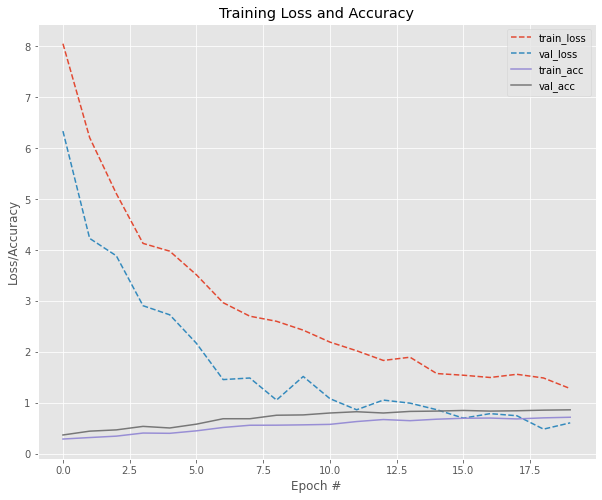

In [24]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [25]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with feature extractor": wandb.Image(fig),
    }
)

22-11-2022 00:30:31 Uploading figures


In [26]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.006241155606919376 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0003179303004587185 kWh
[INFO] Energy consumed for all GPU: 0.0030782167196168504 kWh
[INFO] Energy consumed for all CPU: 0.002845008586843809 kWh
[INFO] CO2 emission 0.003938064108307389(in Kg)


In [27]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [28]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [29]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 0s 176ms/step
              precision    recall  f1-score   support

      Bengal       1.00      1.00      1.00         7
    Keeshond       0.80      1.00      0.89         4
Russian_blue       1.00      0.75      0.86         8
       boxer       1.00      1.00      1.00         7
         pug       0.86      1.00      0.92         6

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.93        32
weighted avg       0.95      0.94      0.94        32



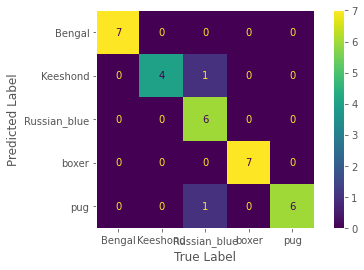

In [30]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [31]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with feature extractor": wandb.Image(fig_confusion_matrix),
    }
)

22-11-2022 00:31:00 Uploading figures


In [32]:
# number of parameters
run.summary["Count_Params transfer learning with feature extractor"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed transfer learning with feature extractor"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM transfer learning with feature extractor"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU transfer learning with feature extractor"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU transfer learning with feature extractor"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions transfer learning with feature extractor"] = tracker.final_emissions_data.emissions

Transfer learning with fine-tuning

In [33]:
# import the necessary packages
from tensorflow.keras.applications import VGG16

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [34]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [36]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [37]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [38]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-t

In [39]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [40]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [41]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [42]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [43]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False


In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [45]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] training head...
Epoch 1/20
24/24 [==============================] - 8s 249ms/step - loss: 9.3055 - accuracy: 0.6319 - val_loss: 0.6027 - val_accuracy: 0.9563
Epoch 2/20
24/24 [==============================] - 7s 241ms/step - loss: 1.8765 - accuracy: 0.8536 - val_loss: 0.5957 - val_accuracy: 0.9688
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 1.2319 - accuracy: 0.8799

22-11-2022 00:32:33 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:32:34 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.8s


24/24 [==============================] - 11s 445ms/step - loss: 1.2319 - accuracy: 0.8799 - val_loss: 0.2578 - val_accuracy: 0.9688
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 1.2875 - accuracy: 0.8918

22-11-2022 00:32:55 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:32:55 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.9s


24/24 [==============================] - 12s 486ms/step - loss: 1.2875 - accuracy: 0.8918 - val_loss: 0.1667 - val_accuracy: 0.9812
Epoch 5/20
24/24 [==============================] - 7s 242ms/step - loss: 0.8333 - accuracy: 0.9288 - val_loss: 0.3186 - val_accuracy: 0.9812
Epoch 6/20
24/24 [==============================] - 7s 241ms/step - loss: 0.8159 - accuracy: 0.9261 - val_loss: 0.3591 - val_accuracy: 0.9750
Epoch 7/20
24/24 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.9393

22-11-2022 00:33:20 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:33:21 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.8s


24/24 [==============================] - 11s 447ms/step - loss: 0.5375 - accuracy: 0.9393 - val_loss: 5.5357e-04 - val_accuracy: 1.0000
Epoch 8/20
24/24 [==============================] - 7s 244ms/step - loss: 0.2878 - accuracy: 0.9631 - val_loss: 0.3335 - val_accuracy: 0.9750
Epoch 9/20
24/24 [==============================] - 7s 255ms/step - loss: 0.4921 - accuracy: 0.9551 - val_loss: 0.0695 - val_accuracy: 0.9937
Epoch 10/20
24/24 [==============================] - 7s 241ms/step - loss: 0.4470 - accuracy: 0.9604 - val_loss: 0.1456 - val_accuracy: 0.9937
Epoch 11/20
24/24 [==============================] - 7s 242ms/step - loss: 0.3072 - accuracy: 0.9499 - val_loss: 0.0256 - val_accuracy: 0.9937
Epoch 12/20
24/24 [==============================] - 7s 256ms/step - loss: 0.3447 - accuracy: 0.9631 - val_loss: 0.2357 - val_accuracy: 0.9875
Epoch 13/20
24/24 [==============================] - 7s 244ms/step - loss: 0.3262 - accuracy: 0.9631 - val_loss: 0.0940 - val_accuracy: 0.9812
Epoch 14

22-11-2022 00:34:50 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:34:51 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.8s


24/24 [==============================] - 12s 460ms/step - loss: 0.1665 - accuracy: 0.9736 - val_loss: 1.7943e-05 - val_accuracy: 1.0000
Epoch 18/20
24/24 [==============================] - 7s 264ms/step - loss: 0.2305 - accuracy: 0.9749 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 19/20
24/24 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9683

22-11-2022 00:35:20 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:35:21 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.8s


24/24 [==============================] - 12s 460ms/step - loss: 0.2375 - accuracy: 0.9683 - val_loss: 8.9926e-07 - val_accuracy: 1.0000
Epoch 20/20
24/24 [==============================] - 7s 247ms/step - loss: 0.3515 - accuracy: 0.9644 - val_loss: 0.0882 - val_accuracy: 0.9875


In [46]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [47]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [49]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [50]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [51]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[wandb.keras.WandbCallback(save_model=True,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] re-compiling model...
[INFO] training head...
Epoch 1/20
24/24 [==============================] - 10s 282ms/step - loss: 0.2762 - accuracy: 0.9736 - val_loss: 0.0059 - val_accuracy: 0.9937
Epoch 2/20
24/24 [==============================] - 7s 266ms/step - loss: 0.1589 - accuracy: 0.9802 - val_loss: 1.3722e-06 - val_accuracy: 1.0000
Epoch 3/20
24/24 [==============================] - 8s 294ms/step - loss: 0.1180 - accuracy: 0.9789 - val_loss: 0.0118 - val_accuracy: 0.9937
Epoch 4/20
24/24 [==============================] - 7s 263ms/step - loss: 0.1504 - accuracy: 0.9789 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 5/20
24/24 [==============================] - 8s 280ms/step - loss: 0.1801 - accuracy: 0.9749 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 6/20
24/24 [==============================] - 7s 261ms/step - loss: 0.0777 - accuracy: 0.9908 - val_loss: 0.0067 - val_accuracy: 0.9937
Epoch 7/20
24/24 [==============================] - 7s 260ms/step - loss: 0.0721 - accurac

22-11-2022 00:38:21 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 13). These functions will not be directly callable after loading.
22-11-2022 00:38:22 Assets written to: /content/wandb/run-20221122_002316-p7jc0u6q/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20221122_002316-p7jc0u6q/files/model-best)... Done. 0.7s


24/24 [==============================] - 13s 458ms/step - loss: 0.0584 - accuracy: 0.9894 - val_loss: 3.7253e-09 - val_accuracy: 1.0000
Epoch 11/20
24/24 [==============================] - 7s 268ms/step - loss: 0.1020 - accuracy: 0.9855 - val_loss: 0.0243 - val_accuracy: 0.9875
Epoch 12/20
24/24 [==============================] - 7s 262ms/step - loss: 0.0877 - accuracy: 0.9881 - val_loss: 3.8404e-04 - val_accuracy: 1.0000
Epoch 13/20
24/24 [==============================] - 7s 264ms/step - loss: 0.0692 - accuracy: 0.9842 - val_loss: 1.5204e-04 - val_accuracy: 1.0000
Epoch 14/20
24/24 [==============================] - 7s 262ms/step - loss: 0.0661 - accuracy: 0.9855 - val_loss: 4.5511e-04 - val_accuracy: 1.0000
Epoch 15/20
24/24 [==============================] - 8s 275ms/step - loss: 0.0917 - accuracy: 0.9828 - val_loss: 0.0050 - val_accuracy: 0.9937
Epoch 16/20
24/24 [==============================] - 7s 263ms/step - loss: 0.0378 - accuracy: 0.9894 - val_loss: 4.2163e-04 - val_accurac

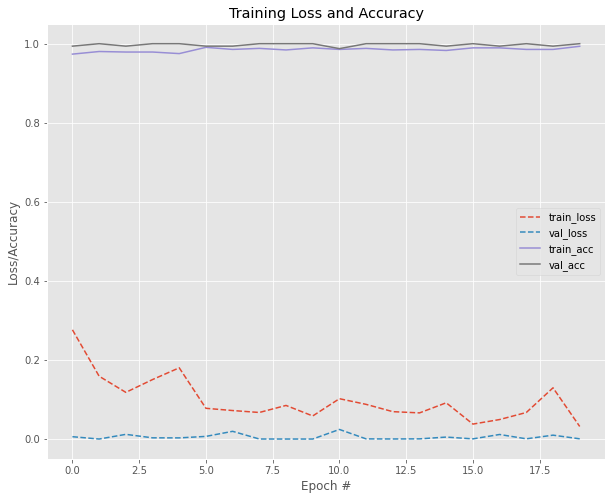

In [52]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [53]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy transfer learning with fine tuning": wandb.Image(fig),
    }
)

22-11-2022 00:44:11 Uploading figures


In [54]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.005131569292669372 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00024467006105019967 kWh
[INFO] Energy consumed for all GPU: 0.0026986369920239182 kWh
[INFO] Energy consumed for all CPU: 0.002188262239595255 kWh
[INFO] CO2 emission 0.003237933825644262(in Kg)


In [55]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [56]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
1/1 [==============================] - 0s 137ms/step
              precision    recall  f1-score   support

      Bengal       1.00      1.00      1.00         3
    Keeshond       1.00      1.00      1.00         9
Russian_blue       1.00      1.00      1.00         8
       boxer       1.00      1.00      1.00         8
         pug       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



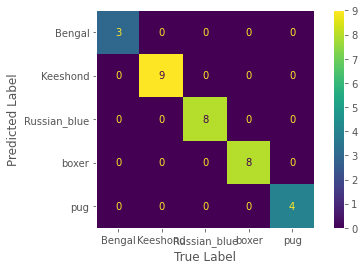

In [57]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [58]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix transfer learning with fine tuning": wandb.Image(fig_confusion_matrix),
    }
)

22-11-2022 00:44:35 Uploading figures


In [59]:
# number of parameters
run.summary["Count_Params transfer learning with fine tuning"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed transfer learning with fine tuning"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM transfer learning with fine tuning"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU transfer learning with fine tuning"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU transfer learning with fine tuning"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions transfer learning with fine tuning"] = tracker.final_emissions_data.emissions

In [60]:
run.finish()

accuracy,▁▁▂▂▃▄▄▄▅▅▅▅▅▅▇▇▇▇██████████████████████
epoch,▁▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▄▅▅▆▇▇█
loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▅▅▅▆▆▆▆▆▆▇██████████████████████████
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CO2_Emissions transfer learning with feature extractor,0.00394
CO2_Emissions transfer learning with fine tuning,0.00324
Count_Params transfer learning with feature extractor,14717253
Count_Params transfer learning with fine tuning,21138757
Energy_CPU transfer learning with feature extractor,0.00285
Energy_CPU transfer learning with fine tuning,0.00219
